Combined DataFrame shape: (25286, 54)
   X1_ActualPosition  X1_ActualVelocity  X1_ActualAcceleration  \
0                198                0.0                   0.00   
1                198              -10.8                -350.00   
2                196              -17.8                  -6.25   
3                194              -18.0                   0.00   
4                193              -17.9                 -18.80   

   X1_CommandPosition  X1_CommandVelocity  X1_CommandAcceleration  \
0                 198                 0.0                0.000000   
1                 198               -13.6             -358.000000   
2                 196               -17.9               -0.000095   
3                 194               -17.9               -0.000095   
4                 192               -17.9                0.000095   

   X1_CurrentFeedback  X1_DCBusVoltage  X1_OutputCurrent  X1_OutputVoltage  \
0                0.18           0.0207               329              2.

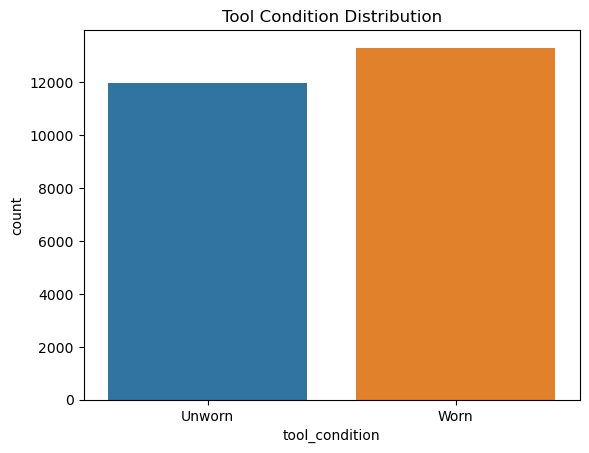

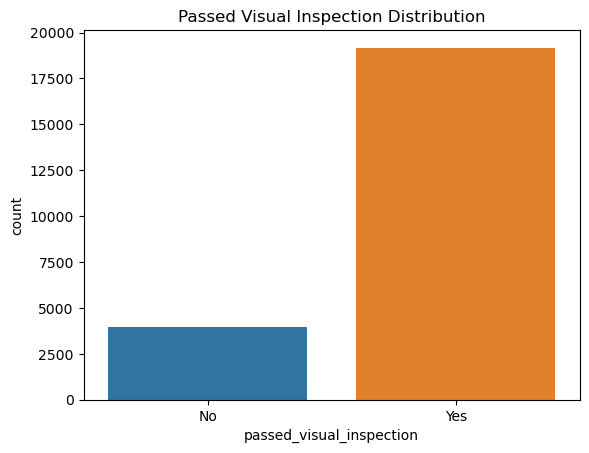

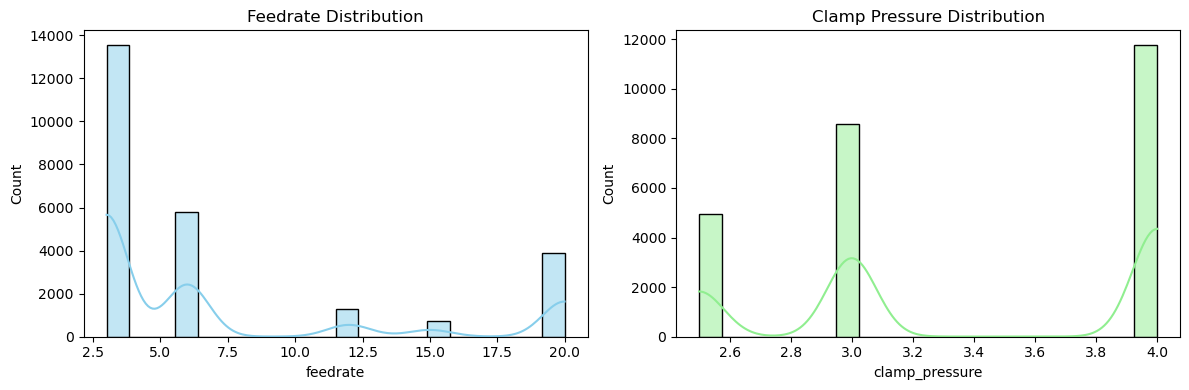

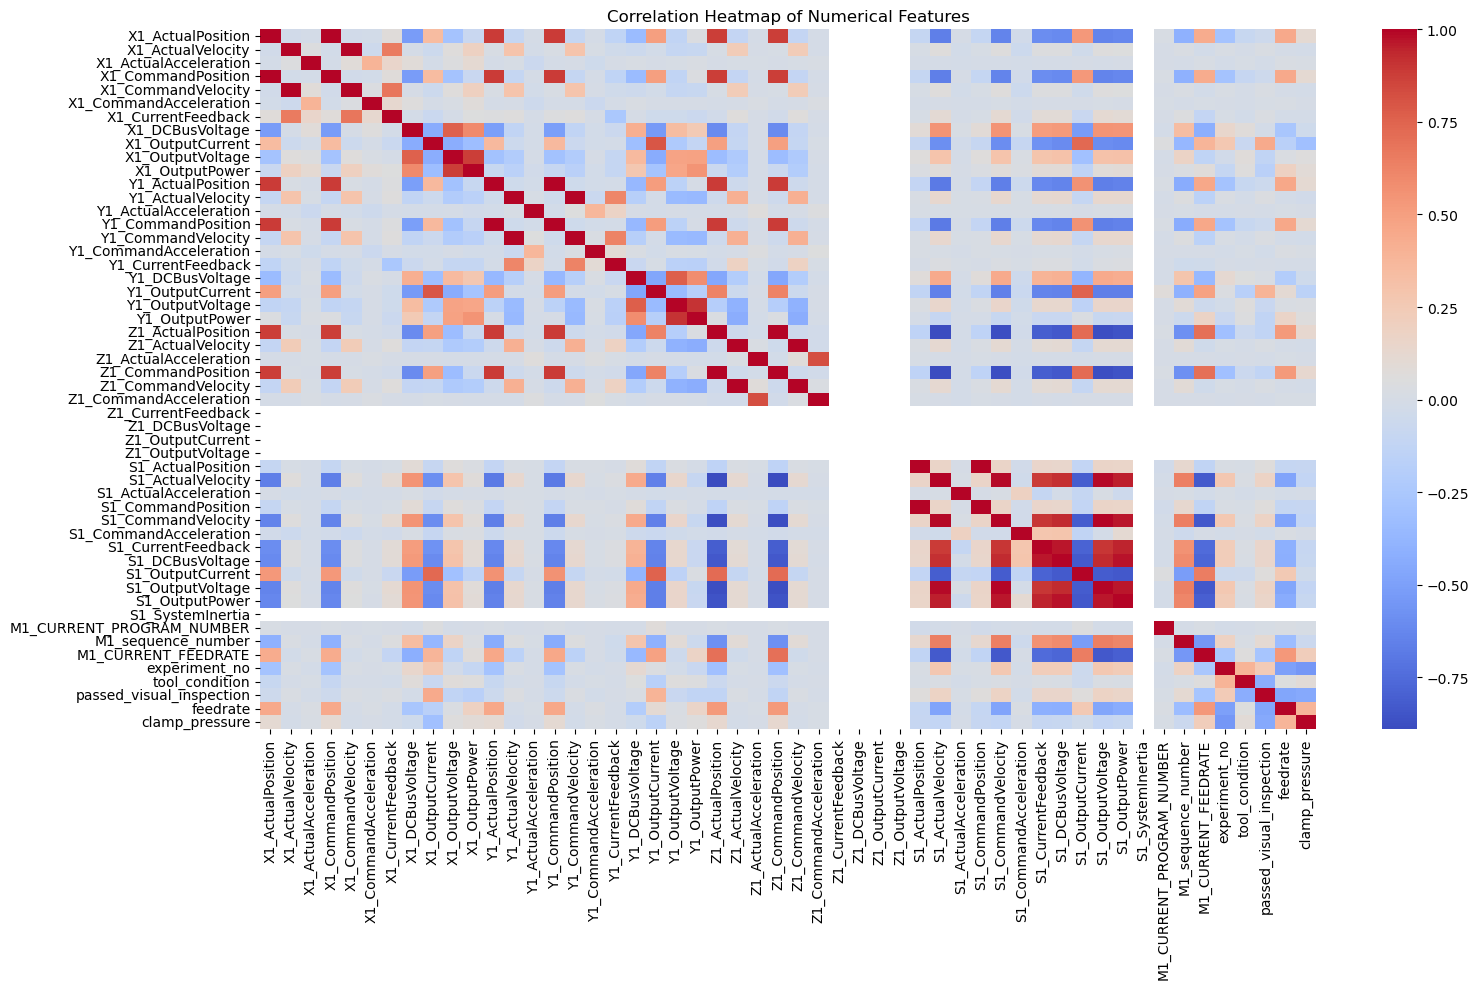

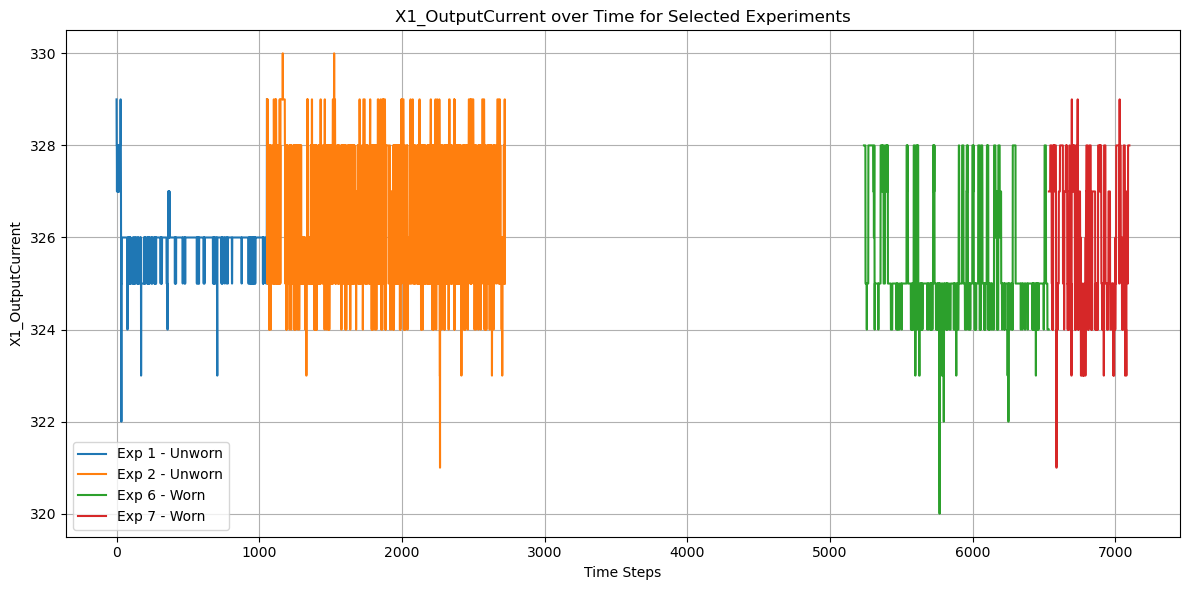

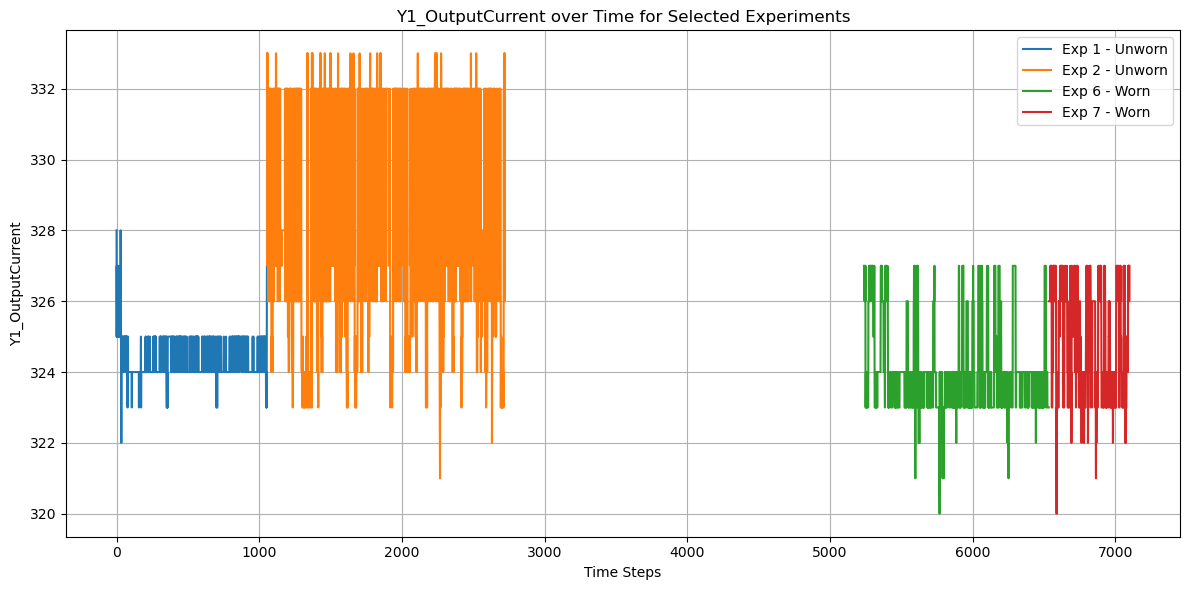

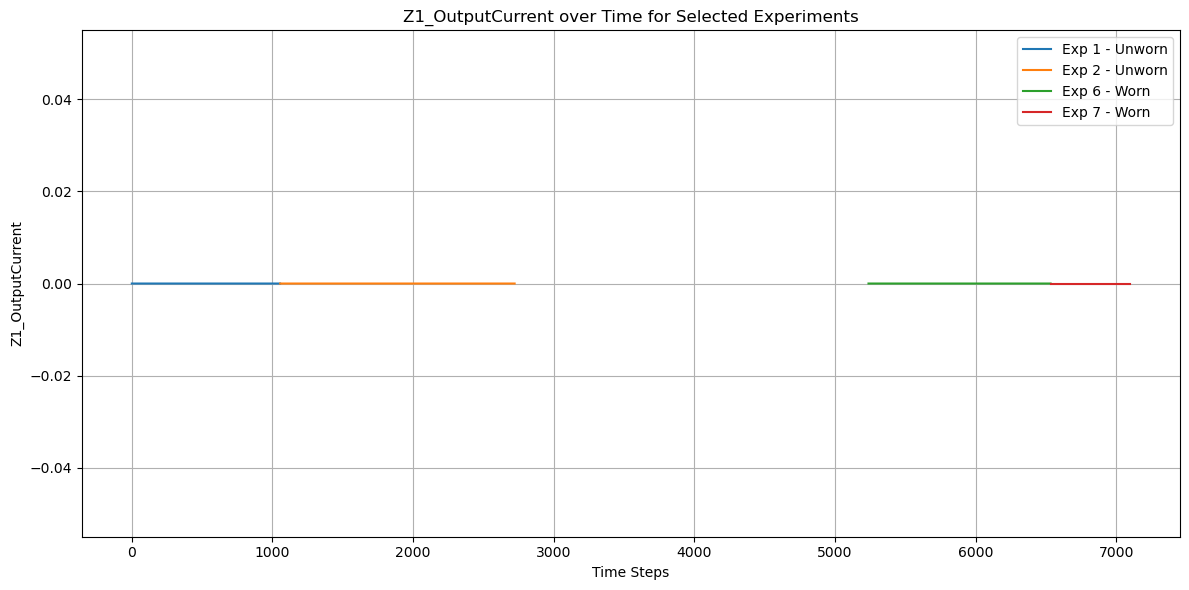

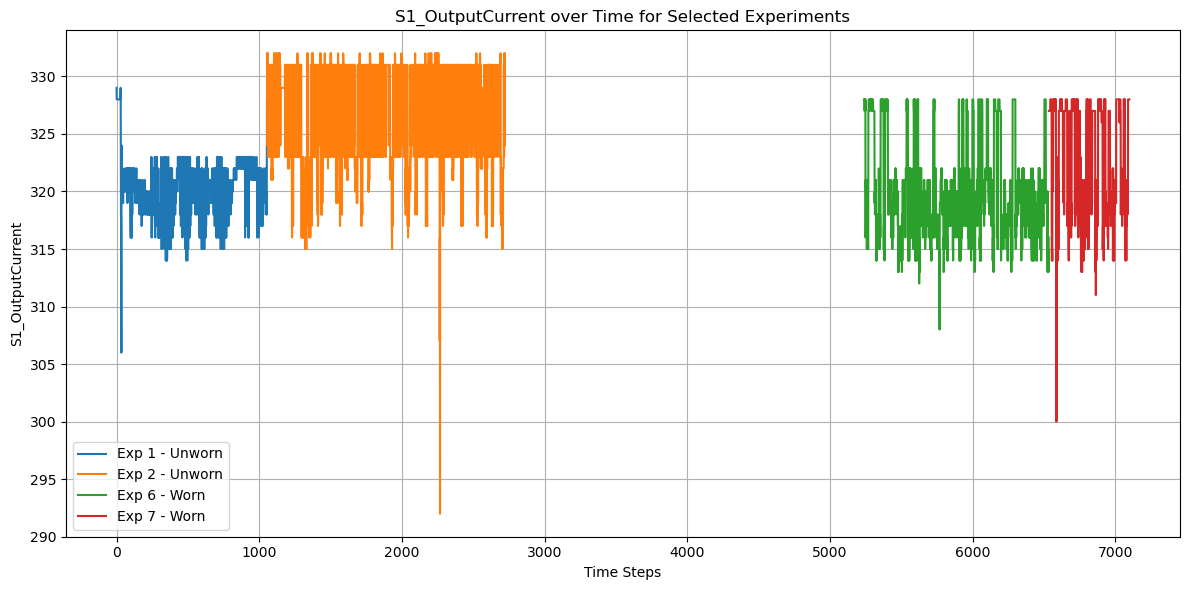

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Base Path for the dataset
base_path = r"C:\IIT Courses\Fourth Semester\Data Driven Modeling\Final Project\CNC Mill Tool Wear\archive"

# Loading metadata
train_path = os.path.join(base_path, "train.csv")
train_df = pd.read_csv(train_path)
train_df['tool_condition'] = train_df['tool_condition'].map({'unworn': 0, 'worn': 1})
train_df['passed_visual_inspection'] = train_df['passed_visual_inspection'].map({'yes': 1, 'no': 0})

# Combining all experiments
all_experiments = []
for i in range(1, 19):  # 1 to 18
    exp_no = f"{i:02}"
    file_path = os.path.join(base_path, f"experiment_{exp_no}.xlsx")
    
    if os.path.exists(file_path):
        df = pd.read_excel(file_path)
        df['experiment_no'] = i

        # Adding labels from train.csv
        row = train_df[train_df['No'] == i].iloc[0]
        df['tool_condition'] = row['tool_condition']
        df['passed_visual_inspection'] = row['passed_visual_inspection']
        df['feedrate'] = row['feedrate']
        df['clamp_pressure'] = row['clamp_pressure']
        df['material'] = row['material']
        
        all_experiments.append(df)
    else:
        print(f"Experiment file {file_path} not found.")

# Combining into one DataFrame
full_df = pd.concat(all_experiments, ignore_index=True)
print("Combined DataFrame shape:", full_df.shape)
print(full_df.head())

# ====== EDA VISUALIZATION ======

# 1. Tool condition distribution
sns.countplot(data=full_df, x='tool_condition')
plt.title("Tool Condition Distribution")
plt.xticks([0,1], ['Unworn', 'Worn'])
plt.show()

# 2. Visual inspection outcome
sns.countplot(data=full_df, x='passed_visual_inspection')
plt.title("Passed Visual Inspection Distribution")
plt.xticks([0,1], ['No', 'Yes'])
plt.show()

# 3. Feedrate and Clamp pressure distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(full_df['feedrate'], bins=20, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title("Feedrate Distribution")
sns.histplot(full_df['clamp_pressure'], bins=20, kde=True, ax=axes[1], color='lightgreen')
axes[1].set_title("Clamp Pressure Distribution")
plt.tight_layout()
plt.show()

# 4. Correlation heatmap for numerical values
numeric_cols = full_df.select_dtypes(include=[np.number])
corr = numeric_cols.corr()
plt.figure(figsize=(16, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()

# ====== SENSOR TREND VISUALIZATION ======

import matplotlib.pyplot as plt

# Picking a few worn and unworn examples for visualization
sample_unworn = full_df[full_df['tool_condition'] == 0]['experiment_no'].unique()[:2]
sample_worn = full_df[full_df['tool_condition'] == 1]['experiment_no'].unique()[:2]

selected_experiments = list(sample_unworn) + list(sample_worn)

# Plotting time-series output current for each axis
sensors = ['X1_OutputCurrent', 'Y1_OutputCurrent', 'Z1_OutputCurrent', 'S1_OutputCurrent']

for sensor in sensors:
    plt.figure(figsize=(12, 6))
    for exp in selected_experiments:
        df_exp = full_df[full_df['experiment_no'] == exp]
        label = f"Exp {exp} - {'Worn' if df_exp['tool_condition'].iloc[0] == 1 else 'Unworn'}"
        plt.plot(df_exp.index, df_exp[sensor], label=label)
    plt.title(f"{sensor} over Time for Selected Experiments")
    plt.xlabel("Time Steps")
    plt.ylabel(sensor)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
